In [1]:
from linares_plot import *
import sys, os
path_tools = 'C:\\Users\\David\\Documents\\GitHub\\encoding\\scripts\\wm_representation\\functions\\IEM\\tools'
sys.path.insert(1, path_tools)
from timecourse import *

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
paths_=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainT_testT_runsout.xlsx', 
               'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainD_testD_runsout.xlsx']

paths_shuff=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainT_testT_runsout.xlsx', 
                     'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainD_testD_runsout.xlsx']


In [9]:
df_=[] ##target ha sido entrenado en el delay del distractor y viceversa
df_shuff=[]

for PathI in paths_:
    path_save_signal =PathI
    #
    decoding_item= path_save_signal.split('\\')[-1].split('.')[0].split('_')[2][-1]
    training_item = path_save_signal.split('\\')[-1].split('.')[0].split('_')[1][-1]
    #
    df_x = pd.read_excel(PathI)
    df_x['decoding_item'] = decoding_item
    df_x['training_item'] =training_item
    
    #
    df_.append(df_x)
    
#
df_=pd.concat(df_, axis=0)
df_['decoding_item'] = df_['decoding_item'].replace(['T', 'D'], ['target', 'distractor'])
df_['training_item'] = df_['training_item'].replace(['T', 'D'], ['target', 'distractor'])


####################

for PathI in paths_shuff:
    path_sh_signal =PathI
    #
    decoding_item= path_sh_signal.split('\\')[-1].split('.')[0].split('_')[3][-1]
    training_item = path_sh_signal.split('\\')[-1].split('.')[0].split('_')[2][-1]
    #
    df_x = pd.read_excel(PathI)
    df_x['decoding_item'] = decoding_item
    df_x['training_item'] =training_item
    
    #
    df_shuff.append(df_x)
    
#
df_shuff=pd.concat(df_shuff, axis=0)
df_shuff['decoding_item'] = df_shuff['decoding_item'].replace(['T', 'D'], ['target', 'distractor'])
df_shuff['training_item'] = df_shuff['training_item'].replace(['T', 'D'], ['target', 'distractor'])

In [16]:
df_time=[]

for cond in ['1_0.2','1_7', '2_0.2', '2_7']:
    for reg in ['visual', 'ips', 'pfc']:
        for subj in ['d001', 's001', 'l001', 'n001', 'b001', 'r001']:
            for training_item in ['target', 'distractor']:
                for decoding_item in ['target', 'distractor']:
                    for t in df_.times.unique(): 
                        #
                        dec_sig = df_.loc[(df_['region']==reg) & (df_['times']== t) & 
                               ( df_['condition']==cond) & (df_['subject']==subj) &  
                               ( df_['training_item']==training_item) & 
                               ( df_['decoding_item']== decoding_item)]
                        #
                        dec_shuff = df_shuff.loc[(df_shuff['region']==reg) & (df_shuff['times']== t) & 
                               ( df_shuff['condition']==cond) & (df_shuff['subject']==subj) &  
                               ( df_shuff['training_item']==training_item)  & 
                               ( df_shuff['decoding_item']== decoding_item) ].decoding
                        #
                        try:
                            decoding_ = (dec_sig.decoding.iloc[0]  - dec_shuff.mean()) / dec_shuff.std()
                            decoding_ = dec_sig.decoding.iloc[0]  - dec_shuff.mean()
                            df_time.append( [t, decoding_, reg, subj, cond, dec_sig.label.iloc[0], training_item, decoding_item] )   
                        except:
                            pass
                        
                        ####
#
df_time = pd.DataFrame(df_time)
df_time.columns=['times', 'decoding', 'region', 'subject', 'condition', 'label', 'training_item', 'decoding_item']

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


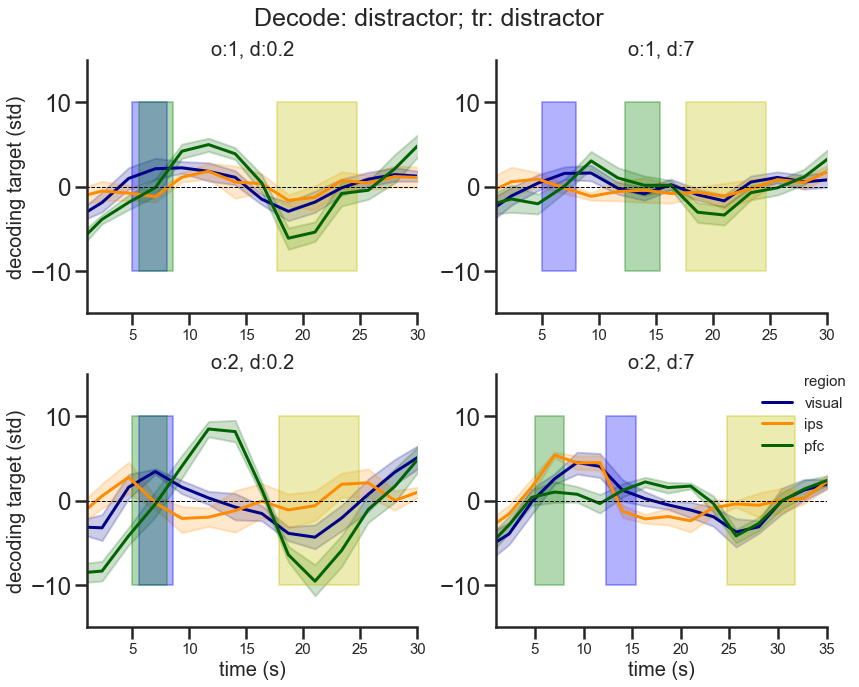

In [20]:
df_x = df_time.loc[df_time['training_item']=='distractor']
tiemcourse(df_x , 'Decode: distractor; tr: distractor', ylims=[-15,15])

In [22]:
df_targ = df_time.loc[(df_time['training_item']=='target') & (df_time['decoding_item']=='target')]
df_dist = df_time.loc[(df_time['training_item']=='distractor') & (df_time['decoding_item']=='distractor')]

In [42]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 29 13:05:33 2019

@author: David
"""


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


presentation_period= 0.35 #stim presnetation time
presentation_period_cue=  0.50 #presentation of attentional cue time
pre_stim_period= 0.5 #time between cue and stim
resp_time = 4  #time the response is active


def tiemcourse_substraction(df_target, df_distractor, condition, title_plot, ylims=[-20,20]):
    ##
    ###
    ####   In the input dataframe you need the following columns:
    ###  'new_mean', 'inf', 'sup', 'brain_reg', 'time', 'condition'
    ## 
    pal = ['darkblue',  'darkorange',  'darkgreen'] #sns.color_palette("tab10", n_colors=12, desat=1).as_hex()[0:3]
    ##
    fig = plt.figure(figsize=(6,15))
    for indx_P, Plot in enumerate(['target', 'distractor', 'substraction']): 
        #features of the plot for the different conditions. Fixed values
        if condition == '1_0.2':
            condition_title = '' #'o:1, d:0.2'
            y_label_cond = 'decoding ' + Plot + ' (std)'
            x_label_cond = ''
            delay1 = 0.2
            delay2 = 11.8
            cue=0
            t_p = cue + presentation_period_cue + pre_stim_period 
            d_p = t_p + presentation_period +delay1 
            r_t = d_p + presentation_period + delay2
            xlim = [1, 30]

        elif condition == '1_7':
            condition_title = '' #'o:1, d:7'
            y_label_cond = '' 
            x_label_cond = ''
            delay1 = 7
            delay2 = 5
            cue=0
            t_p = cue + presentation_period_cue + pre_stim_period 
            d_p = t_p + presentation_period +delay1 
            r_t = d_p + presentation_period + delay2
            xlim = [1, 30]

        elif condition == '2_0.2':
            condition_title = '' #'o:2, d:0.2'
            y_label_cond = 'decoding ' + Plot + ' (std)'
            x_label_cond = 'time (s)'        
            delay1 = 0.2
            delay2 = 12
            cue=0
            d_p = cue + presentation_period_cue + pre_stim_period 
            t_p = d_p + presentation_period +delay1 
            r_t = t_p + presentation_period + delay2   
            xlim = [1, 30]

        elif condition == '2_7':
            condition_title = '' #'o:2, d:7'
            y_label_cond = '' 
            x_label_cond = 'time (s)' 
            delay1 = 7
            delay2 = 12
            cue=0
            d_p = cue + presentation_period_cue + pre_stim_period 
            t_p = d_p + presentation_period +delay1 
            r_t = t_p + presentation_period + delay2
            xlim = [1, 35]


        start_hrf = 4 #start of the Hemodynamic response (4seconds)
        sec_hdrf = 3 #time it can last

        d_p1 = (start_hrf + d_p) ##strat of didtractor (time)
        t_p1 = (start_hrf +t_p) ## strat of target (time)
        r_t1=  (start_hrf + r_t) ## start of response (time)
        #
        d_p2 = d_p1 + sec_hdrf # end of distractor (time)
        t_p2 = t_p1 + sec_hdrf # end of target (time)
        r_t2=  r_t1 + sec_hdrf + resp_time #end of response (time)

        y_vl_min = -10 #df_all_by_subj.Decoding.min() #values min and max
        y_vl_max = 10 #◙df_all_by_subj.Decoding.max()

        #fig = plt.figure()
        ax = fig.add_subplot(3,1, indx_P+1) 

        if Plot=='target':
            data_cond_target = df_target.loc[df_target['condition']==condition ]
            #
            sns.lineplot( ax=ax, x="times", y="decoding", hue='region', ci=68, 
                hue_order =  ['visual', 'ips', 'pfc'], palette=pal, data=data_cond_target)
            #
        elif Plot == 'distractor':
            data_cond_distractor = df_distractor.loc[df_distractor['condition']==condition ]
            #
            sns.lineplot( ax=ax, x="times", y="decoding", hue='region', ci=68, 
                hue_order =  ['visual', 'ips', 'pfc'], palette=pal, data=data_cond_distractor)
            #
        elif Plot =='substraction':
            data_cond_target = df_target.loc[df_target['condition']==condition ]
            data_cond_distractor = df_distractor.loc[df_distractor['condition']==condition ]
            #            
            sns.lineplot( ax=ax, x="times", y="decoding", hue='region', ci=68, 
                hue_order =  ['visual', 'ips', 'pfc'], palette=pal, data=data_cond_target)
            #
        ####
        plt.plot([0, 35], [0,0], 'k--', linewidth=1)   ## plot chance level (0)
        plt.fill_between(  [ t_p1, t_p2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='b', alpha=0.3) #, label='target'  ) #plot aprox time of target
        plt.fill_between(  [ d_p1, d_p2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='g', alpha=0.3) #, label='distractor'  ) #plot aprox time of distractor
        plt.fill_between(  [ r_t1, r_t2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='y', alpha=0.3) #, label='response'  )   #plot aprox time of response
        #
        TITLE_BR = condition_title 
        plt.title(TITLE_BR, fontsize=20) #condition title
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.xticks([5,10,15,20,25,30,35], fontsize=15) #just this tcks
        plt.ylim(ylims[0], ylims[1])
        if ylims[0]==-20:
            plt.yticks([-20, -10, 0 , 10, 20], fontsize=15)
        if ylims[0]==-30:
            plt.yticks([-30, -15, 0 , 15, 30], fontsize=15)
        #
        plt.xlim(xlim)
        plt.xlabel(x_label_cond, fontsize=20)
        plt.ylabel(y_label_cond, fontsize=20)
        if indx_P==2: #legend in just this condition (to avoid repetitions)       
            plt.gca().legend(loc=1, frameon=False, bbox_to_anchor=(1.1, 0.45), fontsize=15)
            plt.xticks([5,10, 15, 20, 25,30,35], fontsize=15)

        else:
            plt.gca().legend(loc= 1, frameon=False).remove()



    ##
    plt.suptitle( title_plot, fontsize=25) ## main title
    plt.tight_layout(w_pad=1, h_pad=1, rect=[0, 0.03, 1, 0.95]) #correct the space between graphs
    plt.show(block=False) #show
    

In [47]:
df_targ = df_time.loc[(df_time['training_item']=='target') & (df_time['decoding_item']=='target')]
df_dist = df_time.loc[(df_time['training_item']=='distractor') & (df_time['decoding_item']=='distractor')]

In [48]:
df_targ = df_targ.loc[df_targ['condition']== '1_0.2' ]
df_dist = df_dist.loc[df_dist['condition']== '1_0.2' ]

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


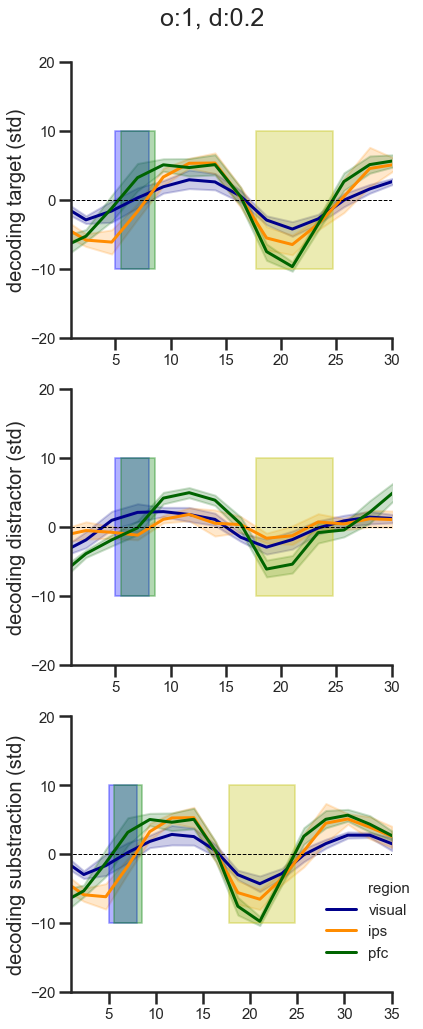

In [43]:
tiemcourse_substraction(df_targ, df_dist, condition='1_0.2', title_plot='o:1, d:0.2')